In [130]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In this exercise, let us find out if there are different patterns for users between different weekdays and between different hours.

---
## Setting up a connection

In [131]:
con = sqlite3.connect('../data/checking-logs.sqlite')

---
## Checking `checker` table's content

In [132]:
pd.read_sql('SELECT name FROM sqlite_master WHERE type="table"', con)

,name
0,pageviews
1,checker
2,deadlines
3,datamart
4,test
5,control


In [133]:
pd.read_sql('SELECT * FROM checker LIMIT 10', con)

,index,status,success,timestamp,numTrials,labname,uid
0,0,checking,0,2020-04-16 21:12:50.740474,5,None,admin_1
1,1,ready,0,2020-04-16 21:12:54.708365,5,code_rvw,admin_1
2,2,checking,0,2020-04-16 21:46:47.769088,7,None,admin_1
3,3,ready,0,2020-04-16 21:46:48.121217,7,lab02,admin_1
4,4,checking,0,2020-04-16 21:53:01.862637,6,code_rvw,admin_1
5,5,ready,0,2020-04-16 21:53:05.373389,6,code_rvw,admin_1
6,6,checking,0,2020-04-17 05:18:51.965864,1,None,None
7,7,ready,0,2020-04-17 05:19:02.744528,1,project1,user_4
8,8,checking,0,2020-04-17 05:22:35.249331,2,project1,user_4
9,9,ready,1,2020-04-17 05:22:45.549397,2,project1,user_4


---
## Arranging dataframe for heatmap

For this task we will need `checker` table.\
For creating heatmap as subject requires we need to count ***absolute*** number of `commits` grouped by day of the week and number of `commits` grouped by hour.\
So we will have 2 dataframes: `commits_by_day`, `commits_by_hour`

In [134]:
query = """
SELECT
    uid,
    timestamp
FROM
    checker
WHERE
    uid LIKE 'user_%'
"""
df_all = pd.read_sql(query, con, parse_dates='timestamp')
df_all['weekday'] = df_all.timestamp.dt.day_name().apply(lambda x: x[:3])
df_all['hour'] = df_all.timestamp.dt.hour
df_all

,uid,timestamp,weekday,hour
0,user_4,2020-04-17 05:19:02.744528,Fri,5
1,user_4,2020-04-17 05:22:35.249331,Fri,5
2,user_4,2020-04-17 05:22:45.549397,Fri,5
3,user_4,2020-04-17 05:34:14.691200,Fri,5
4,user_4,2020-04-17 05:34:24.422370,Fri,5
...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,Thu,20
3203,user_1,2020-05-21 20:22:41.785725,Thu,20
3204,user_1,2020-05-21 20:22:41.877806,Thu,20
3205,user_1,2020-05-21 20:37:00.129678,Thu,20


In [135]:
commits_by_day = df_all.loc[:, ~df_all.columns.isin(['timestamp', 'hour'])]
commits_by_day.set_index('weekday', inplace=True)
commits_by_day

,uid
weekday,
Fri,user_4
Fri,user_4
Fri,user_4
Fri,user_4
Fri,user_4
...,...
Thu,user_1
Thu,user_1
Thu,user_1


In [136]:
commits_by_hour = df_all.loc[:, ~df_all.columns.isin(['timestamp', 'weekday'])]
commits_by_hour.set_index('hour', inplace=True)
commits_by_hour

,uid
hour,
5,user_4
5,user_4
5,user_4
5,user_4
5,user_4
...,...
20,user_1
20,user_1
20,user_1


---
## Dataframe users by hours

In [137]:
hours = pd.get_dummies(commits_by_hour['uid'])
hours = hours.groupby('hour').agg(sum)

for i in range(24):
    if i not in hours.index:
        hours.loc[i] = [0] * len(hours.columns)
        
hours.sort_index(inplace=True)
hours = hours[hours.sum().sort_values(ascending=False).index]
hours

,user_4,user_14,user_2,user_25,user_19,user_26,user_20,user_31,user_10,user_3,...,user_17,user_16,user_27,user_15,user_6,user_7,user_22,user_11,user_23,user_0
hour,,,,,,,,,,,,,,,,,,,,,
0,0,4,0,0,0,4,0,2,0,0,...,0,0,0,0,2,0,0,0,0,0
1,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,13,0,2,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,3,6,0,0,10,2,0,3,0,...,1,0,0,0,0,0,0,0,0,0
8,0,6,0,0,0,5,2,0,9,6,...,2,0,0,0,0,1,0,0,1,0


---
## Dataframe by weekdays

In [138]:
days = pd.get_dummies(commits_by_day['uid'])
days = days.groupby('weekday').agg(sum)
        
days = days[days.sum().sort_values(ascending=False).index]
days = days.reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
days

,user_4,user_14,user_2,user_25,user_19,user_26,user_20,user_31,user_10,user_3,...,user_17,user_16,user_27,user_15,user_6,user_7,user_22,user_11,user_23,user_0
weekday,,,,,,,,,,,,,,,,,,,,,
Mon,35,50,24,14,7,0,23,5,0,46,...,8,10,0,0,1,0,2,0,0,3
Tue,86,87,131,44,9,1,0,0,16,11,...,4,5,0,0,0,5,3,0,0,0
Wed,33,0,32,15,0,34,8,0,37,0,...,1,0,0,0,4,3,0,0,0,0
Thu,108,17,4,40,78,51,96,7,77,7,...,17,14,15,5,2,0,2,0,6,0
Fri,61,0,0,10,10,2,7,35,1,59,...,0,0,0,0,0,0,0,0,0,0
Sat,0,79,31,66,21,16,3,90,4,3,...,32,0,0,4,2,0,0,0,0,0
Sun,45,26,13,44,51,69,28,7,2,8,...,0,31,27,20,9,0,1,8,0,0


---
## Heatmap

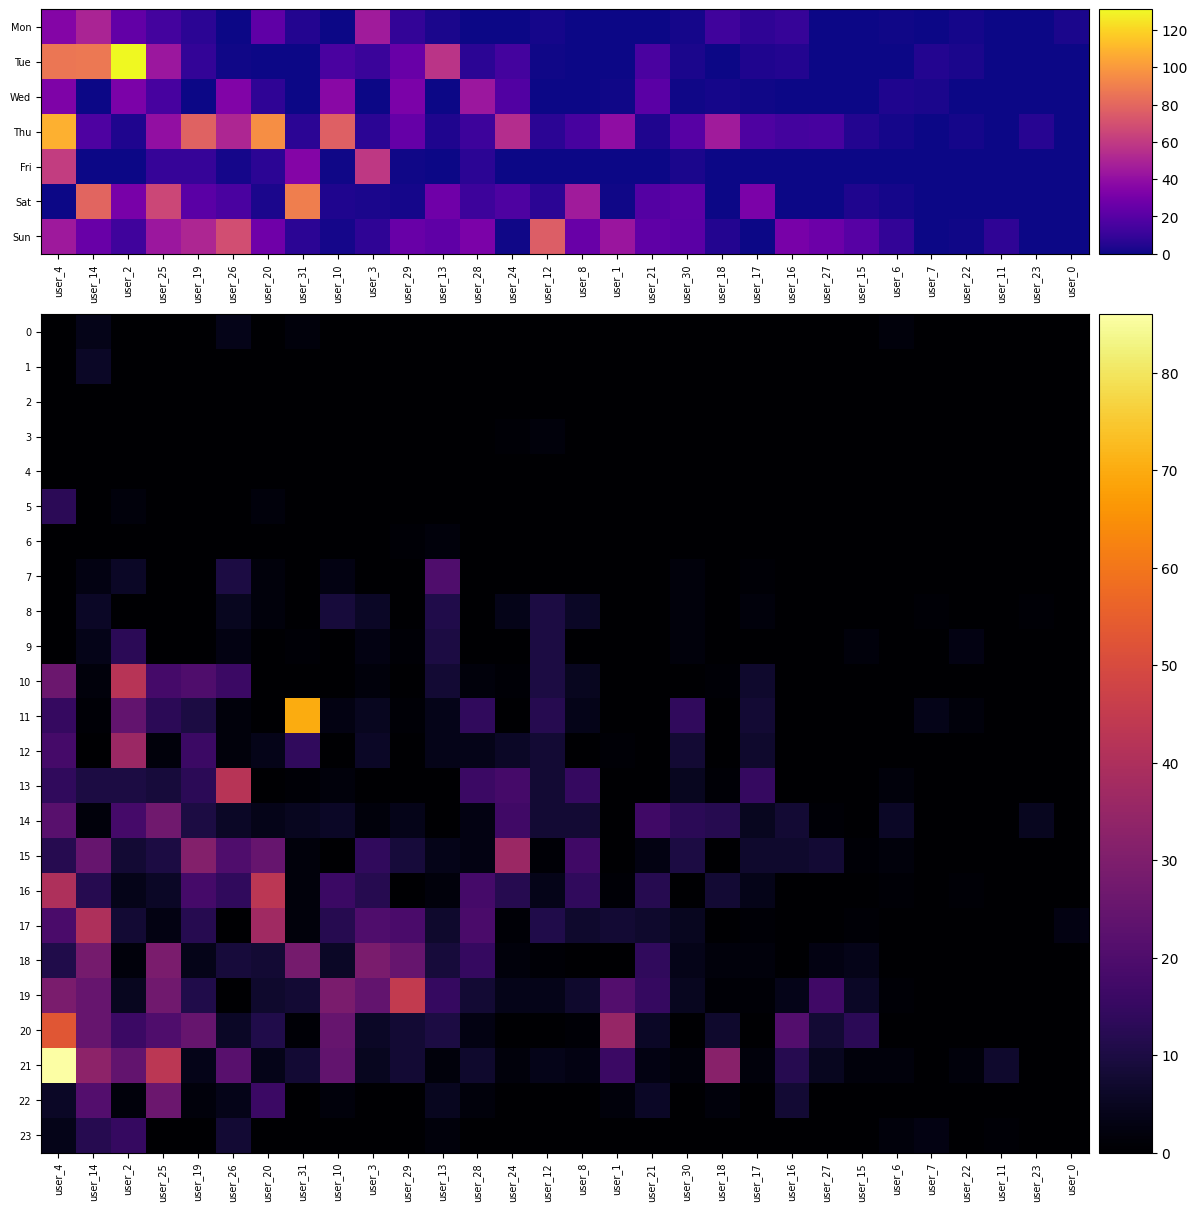

In [139]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 12), constrained_layout=True, gridspec_kw={'height_ratios': [7, 24]})

# -------- commits by day of the week -------- #
im1 = ax1.imshow(days, cmap='plasma')
ax1.set_xticks(range(len(days.columns)), labels=days.columns.to_list())
ax1.set_yticks(range(len(days.index)), labels=days.index.to_list())

plt.setp(ax1.get_xticklabels(), rotation=90, fontsize=7)
plt.setp(ax1.get_yticklabels(), fontsize=7)

ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes('right', size='5%', pad='1%')
cb1 = fig.colorbar(im1, cax=cax1)
# -------------------------------------------- #

# ------------- commits by hours ------------- #
im2 = ax2.imshow(hours, cmap='inferno')
ax2.set_xticks(range(len(hours.columns)), labels=hours.columns.to_list())
ax2.set_yticks(range(len(hours.index)), labels=hours.index.to_list())

plt.setp(ax2.get_xticklabels(), rotation=90, fontsize=7)
plt.setp(ax2.get_yticklabels(), fontsize=7)

ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes('right', size='5%', pad='1%')
cb2 = fig.colorbar(im2, cax=cax2)
# -------------------------------------------- #

plt.show()

---
## Closing the connection

In [140]:
con.close()

---
## Questions

1. Which `user` has the ***most commits*** on `Tue`?
> `user_2`
1. Which `user` has the ***most commits*** on `Thu`?
> `user_4`
1. On which `weekday` do the `users` ***not*** like making a ***lot of commits***?
> `Fri`
1. Which `user` at which `hour` made the ***largest number of commits***?
> `user_4` at `21`